In [146]:
# Load needed modules
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import pandas as pd
import numpy as np
import os
import math

In [276]:
# Update datasets
!cd covid-19-data; git pull

Already up to date.


In [242]:
# Load NYT dataset
nyt_state_filepath = './covid-19-data/us-states.csv'
nyt_state_df = pd.read_csv(nyt_state_filepath)
nyt_state_df.date = pd.to_datetime(nyt_state_df.date)
nyt_state_df = nyt_state_df.set_index(nyt_state_df.date)[['state', 'fips', 'cases', 'deaths']]

In [277]:
## Build dictionary of state data.
per_state_data = {}
idx = nyt_state_df.index.to_pydatetime()
for s, g in nyt_state_df.groupby(nyt_state_df.state):
    daily_new_cases = (g.cases-g.cases.shift(1))
    daily_new_deaths = (g.deaths.shift(1)-g.deaths)
    state_data_df = pd.DataFrame({'cases':g.cases, 'new_cases':daily_new_cases,
                                  'deaths':g.deaths, 'new_deaths':daily_new_deaths}, index=g.index).dropna()
    per_state_data[s] = state_data_df

# get min and max date
min_date = min(per_state_data['Illinois'].index)
max_date = max(per_state_data['Illinois'].index)
for state in per_state_data:
    min_date = min(min_date, min(per_state_data[state].index))
    max_date = max(max_date, max(per_state_data[state].index))

In [ ]:
git@github.com:CSSEGISandData/COVID-19.git

In [263]:
## Produce animation over all days
def time_animated_2d_scatter(dfs, x='cases', y='new_cases',
                             xname=None, yname=None,
                             trail_length=5):
    """
    Function to plot an animation over time of two variables.

    Named Arguments
        dfs: A dictionary of pandas dataframes. The key is the name you want
            that data labelled as. The dataframe should be date indexed, and contain
            'cases' and 'new_cases' columns.

    Keyword Arguments
        x: A string name of the column to use for the x axis.

        y: A string name of the column to use for the y axis.

        xname: Name to use for the x axis.

        yname: Name to use for the y axis.
        
        trail_length: An integer specifying how many points of the past to show.

    returns: A Matplotlib FuncAnimation object containing the animation.
    """

    if xname is None:
        xname = x
    if yname is None:
        yname = y
    
    # Get list of names
    names = list(dfs.keys())

    # Find min and max cases and new_cases
    max_x = 0
    max_y = 0
    for name in names:
        max_x = max(max_x, max(dfs[name][x]))
        max_y = max(max_y, max(dfs[name][y]))

    # Initialization for animation
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    fig, ax = plt.subplots(1, figsize=(15, 5))

    # Lines for histories
    line_plots_x = {}
    line_plots_y = {}
    line_histories = {}
    for name in names:
        line_plots_x[name] = []
        line_plots_y[name] = []
        line_histories[name], = ax.plot(line_plots_x[name], line_plots_y[name], '-', color='k', alpha=0.6)

    # state current positions
    # Initialize
    pos_x = np.zeros((len(names),))
    pos_y = np.zeros((len(names),))
    pos_scat = ax.scatter(pos_x, pos_y, marker='o', alpha=1., s=30)

    # label positions
    labels = {}
    for name in names:
        labels[name] = ax.text(0,0, name, fontsize=9)

    # Plot initialization function
    def init_():
        ax.set_xlim((1, 10**(math.log10(max_x)*1.05)))
        ax.set_ylim((1, 10**(math.log10(max_y*1.05))))
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlabel(xname)
        ax.set_ylabel(yname)
        ax.grid(True)

    # Plot update function
    def update_(cur_date):
        ## Update data for each day
        for name in names:
            df = dfs[name]
            if cur_date in df.index:
                xval = df[cur_date:cur_date][[x]].values[0,0]
                yval = df[cur_date:cur_date][[y]].values[0,0]
                # Update data for that day
                # Label locations
                labels[name].set_position((xval,yval))
                # Lines
                line_plots_x[name].append(xval)
                line_plots_y[name].append(yval)
                if len(line_plots_x[name]) > trail_length:
                    del line_plots_x[name][0]
                if len(line_plots_y[name]) > trail_length:
                    del line_plots_y[name][0]
                # dot positions
                pos_x[names.index(name)] = xval
                pos_y[names.index(name)] = yval

        # Set title
        ax.set_title(f"{pd.to_datetime(str(cur_date)).strftime('%Y-%m-%d')}")

        # Reset object data
        for state in line_histories:
            line_histories[state].set_data(line_plots_x[state], line_plots_y[state])
            pos_scat.set_offsets(list(zip(pos_x, pos_y)))

    # Produce animation
    ani = animation.FuncAnimation(fig, update_, frames=pd.date_range(min_date, max_date),
                                  init_func=init_, blit=False)

    plt.close()
    
    return ani

In [272]:
def time_2d_plot(dfs, x='cases', y='new_cases',
                 xname=None, yname=None):
    """
    2d plot of various datasets over full history.
    
    Named Arguments
        dfs: A dictionary of pandas dataframes for individual populations.
            Each pandas dataframe should be indexed by date with the x and y
            columns of interest.

    Keyword Arguments
        x: A string name of the column to use for the x axis.

        y: A string name of the column to use for the y axis.

        xname: Name to use for the x axis.

        yname: Name to use for the y axis.

    returns: fig, ax -> Matplotlib Figure and Axes objects on which the
        result is plotted.
    """

    if xname is None:
        xname = x
    if yname is None:
        yname = y

    names = list(dfs.keys())

    # Find min and max x and y
    max_x = 0
    max_y = 0
    for name in names:
        max_x = max(max_x, max(dfs[name][x]))
        max_y = max(max_y, max(dfs[name][y]))

    # Plot initialization
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    fig, ax = plt.subplots(1, figsize=(15, 5))
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel(xname)
    ax.set_ylabel(yname)
    ax.grid(True)

    for name in names:
        ax.plot(dfs[name][x], dfs[name][y], '-o', markersize=3, label=name)

    plt.legend()

    return fig, ax

In [273]:
def plot_over_time(dfs, y='cases', yname=None):
    """
    Plot of property over time.
    
    Named Arguments
        dfs: A dictionary of pandas dataframes. keys should be the name of each dataset.
            The dataframe should be indexed by date and contain column of interest.
    
    Keyword Arguments
        y: The string name of the column to plot on the y axis.
        
        yname: The Title of the y axis to use.

    returns: (fig, ax) where fig is a Matplotlib Figure object, and ax is a
        Matplotlib Axes object where the plot is drawn.
    """
    
    if yname is None:
        yname = y

    names = list(dfs.keys())

    min_date = None
    max_date = None
    max_y = None
    for name in names:
        if min_date is None:
            min_date = min(dfs[name].index)
            max_date = max(dfs[name].index)
            max_y = max(dfs[name][y])
        else:
            min_date = min(min_date, min(dfs[name].index))
            max_date = max(max_date, max(dfs[name].index))
            max_y = max(max_y, max(dfs[name][y]))

    fig, ax = plt.subplots(1, figsize=(15,5))
    ax.set_yscale('log')
    ax.set_ylabel(yname)
    ax.set_xlabel('Date')
    ax.set_title('Total cases over time')
    for name in names:
        ax.plot(dfs[name].index, dfs[name][y], '-o', markersize=3, label=name)

    ax.legend()
    ax.grid()

    return fig, ax

In [280]:
states = ['New York', 'Washington', 'Illinois', 'New Jersey']
ani = time_animated_2d_scatter({k: per_state_data[k] for k in states & per_state_data.keys()},
                               x='cases', y='new_cases', xname='Total Cases',
                               yname='Total New Cases', trail_length=10)
HTML(ani.to_jshtml())

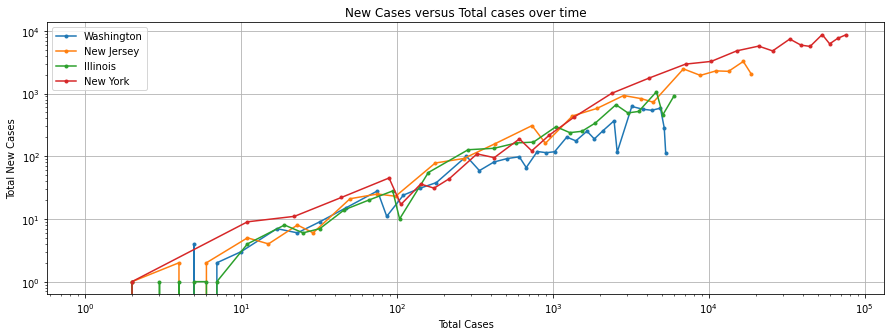

In [279]:
states = ['New York', 'Washington', 'Illinois', 'New Jersey']
_, ax = time_2d_plot({k: per_state_data[k] for k in (states & per_state_data.keys())},
                     x='cases', y='new_cases',
                     xname='Total Cases',
                     yname='Total New Cases')
ax.set_title('New Cases versus Total cases over time')
plt.show()

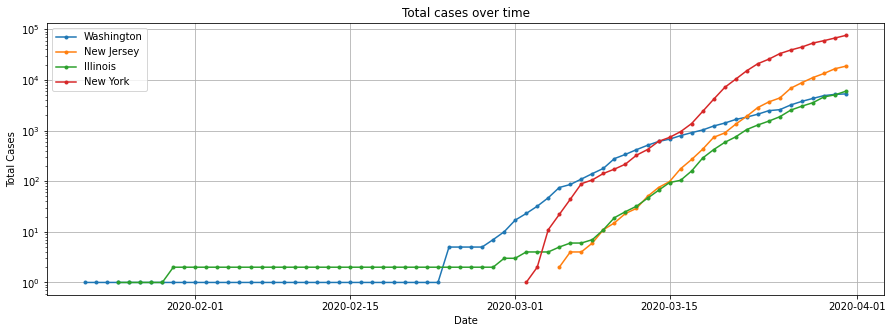

In [278]:
_, ax = plot_over_time({k: per_state_data[k] for k in states & per_state_data.keys()},
               y='cases', yname='Total Cases')
ax.set_title('Total cases over time')
plt.show()

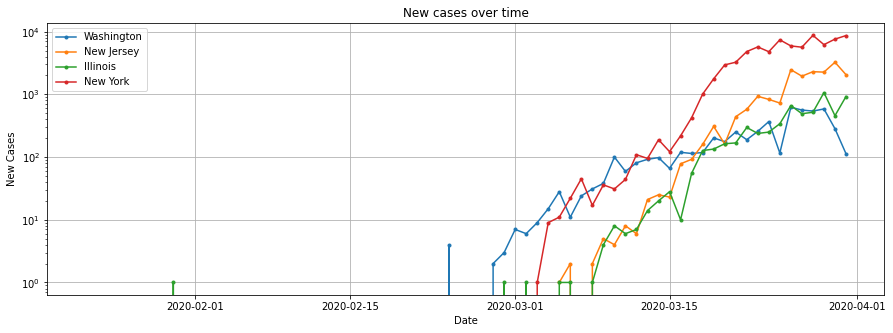

In [275]:
_, ax = plot_over_time({k: per_state_data[k] for k in states & per_state_data.keys()},
                       y='new_cases',
                       yname='New Cases')
ax.set_title('New cases over time')
plt.show()